In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

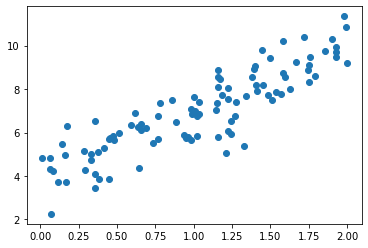

In [4]:
plt.scatter(X,y)

Computing from The Normal Equation

In [5]:
X_b = np.c_[np.ones((100,1)), X]

In [6]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [7]:
theta_best

array([[3.91490198],
       [2.97132661]])

In [8]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]

In [9]:
y_predict = X_new_b.dot(theta_best)

In [10]:
y_predict

array([[3.91490198],
       [9.85755521]])

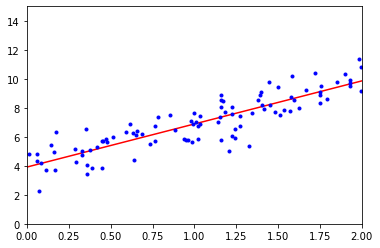

In [11]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

Using LinearRegression Class of SciKit Learn

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
lin_reg = LinearRegression(n_jobs = -1)
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.91490198]), array([[2.97132661]]))

In [14]:
lin_reg.predict(X_new)

array([[3.91490198],
       [9.85755521]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for “least squares”), which you could call directly:

In [15]:
theta_best_svd, residual, rank, s = np.linalg.lstsq(X_b,y,rcond=1e-6)
theta_best_svd

array([[3.91490198],
       [2.97132661]])

This function computes θˆ=(X+)y, where X+ is the pseudoinverse of X (specifically, the Moore-Penrose inverse). You can use np.linalg.pinv() to compute the pseudoinverse directly:

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[3.91490198],
       [2.97132661]])

The pseudoinverse itself is computed using a standard matrix factorization technique called Singular Value Decomposition (SVD) that can decompose the training set matrix X into the matrix multiplication of three matrices U Σ V⊺ (see numpy.linalg.svd()). The pseudoinverse is computed as (X+)=V(Σ+)(U⊺). To compute the matrix Σ+, the algorithm takes Σ and sets to zero all values smaller than a tiny threshold value, then it replaces all the nonzero values with their inverse, and finally it transposes the resulting matrix. This approach is more efficient than computing the Normal Equation, plus it handles edge cases nicely: indeed, the Normal Equation may not work if the matrix (X⊺)X is not invertible (i.e., singular), such as if m < n or if some features are redundant, but the pseudoinverse is always defined.

### Computational Complexity

The Normal Equation computes the inverse of X⊺ X, which is an (n + 1) × (n + 1) matrix (where n is the number of features). The computational complexity of inverting such a matrix is typically about O(n2.4) to O(n3), depending on the implementation. In other words, if you double the number of features, you multiply the computation time by roughly 2^2.4 = 5.3 to 2^3 = 8.

The SVD approach used by Scikit-Learn’s LinearRegression class is about O(n^2). If you double the number of features, you multiply the computation time by roughly 4.

## Batch Gradient Descent

In [17]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100

theta_path_bgd = []

theta = np.random.randn(2,1)  # random initialization
print(theta)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    # print(gradients)
    theta_path_bgd.append(theta)

[[-0.32484268]
 [-0.01918088]]


In [18]:
theta

array([[3.91490198],
       [2.97132661]])

## Stochastic Gradient Descent

In [19]:
theta_path_sgd = []

n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

In [20]:
theta

array([[3.97127635],
       [2.96791243]])

In [21]:
from sklearn.linear_model import SGDRegressor

In [22]:
sgd_reg = SGDRegressor(max_iter = 1000, tol=1e-3, penalty = None, eta0 = 0.1)

In [23]:
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=0.001, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [24]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.87590486]), array([2.95509563]))

## Mini-Batch Gradient Descent

In [25]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)

t0, t1 = 200, 1000

m=len(X_b)

t=0
for epoch in range(n_iterations):
  shuffled_indices = np.random.permutation(m)
  X_b_shuffled = X_b[shuffled_indices]
  y_shuffled = y[shuffled_indices]
  for i in range(0,m,minibatch_size):
    t += 1
    xi = X_b_shuffled[i:i+minibatch_size]
    yi = y_shuffled[i:i+minibatch_size]
    gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
    eta = learning_schedule(t)
    theta = theta - eta * gradients
    theta_path_mgd.append(theta)

In [26]:
theta

array([[3.98868167],
       [3.07274339]])

In [27]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

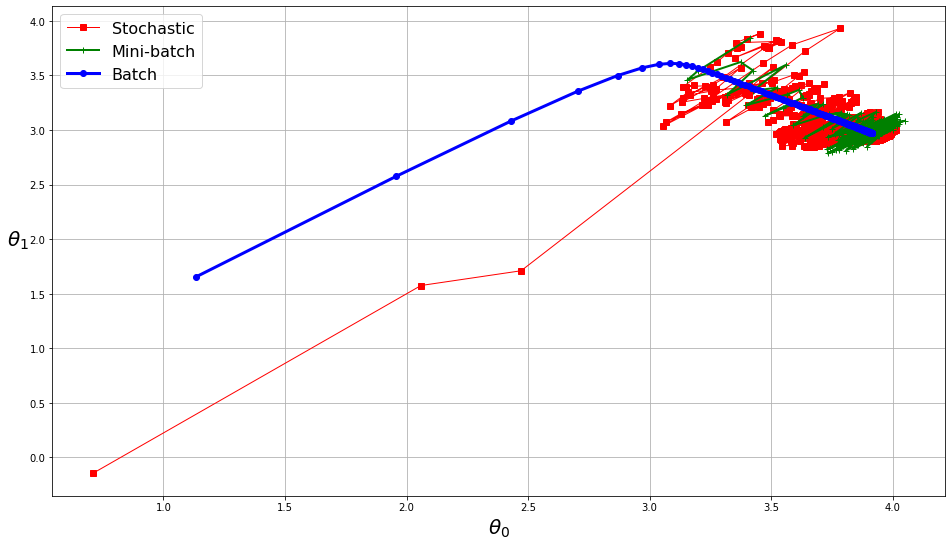

In [28]:
plt.figure(figsize=(16,9))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
# plt.axis([2.5, 4.5, 2.3, 3.9])
plt.grid(True)
plt.show()

#  Comparison of algorithms for Linear Regression

- m is the number of training instances and n is the number of features

| Algorithm | Large m | Out-of-core Support | Large n | Hyperparams | Scaling Required | Scikit-Learn |
| --- | --- | --- | --- | --- | --- | --- |
| Normal Equation | Fast | No | Slow | 0 | No | N/A |
| SVD | Fast | No | Slow | 0 | No | LinearRegression |
| Batch GD | Slow | No | Fast | 2 | Yes | SGDRegressor |
| Stochastic GD | Fast | Yes | Fast | >=2 | Yes | SGDRegressor |
| Mini-Batch GD | Fast | Yes | Fast | >=2 | Yes | SGDRegressor |

# Polynomial Regression

In [29]:
m = 100
X = 6 * np.random.rand(m,1) - 3
y = 2.5 * X**2 + 3 * X + 8 + np.random.randn(m,1)

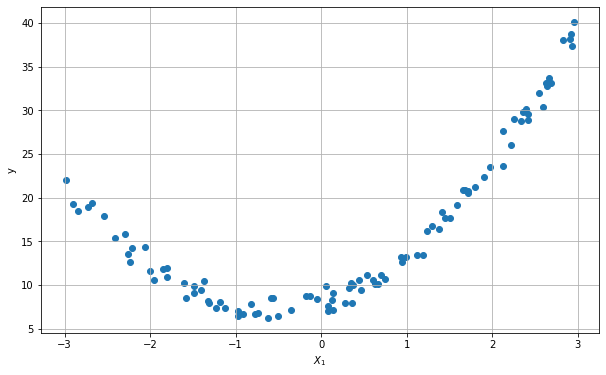

In [30]:
plt.figure(figsize = (10,6))
plt.scatter(X,y)
plt.xlabel("$X_1$")
plt.ylabel("y")
plt.grid(True)
plt.show()

In [31]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree = 2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [32]:
X[0]

array([2.38942838])

In [33]:
X_poly[0]

array([2.38942838, 5.709368  ])

In [34]:
lin_reg = LinearRegression()

lin_reg.fit(X_poly,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [35]:
lin_reg.intercept_, lin_reg.coef_

(array([7.9735233]), array([[2.95038538, 2.52577032]]))

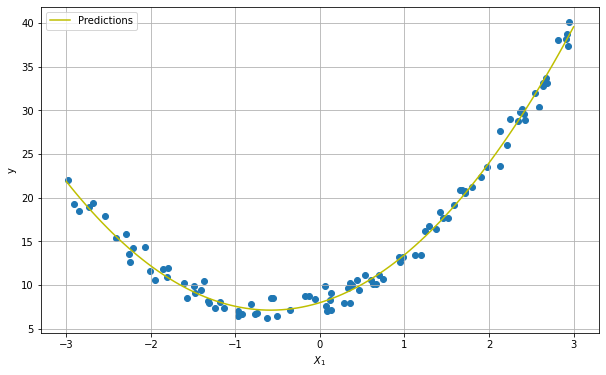

In [36]:
X_for_plot = np.linspace(-3,3,100).reshape(100,1)
X_poly_plot = poly_features.transform(X_for_plot)
y_for_plot = lin_reg.predict(X_poly_plot)

plt.figure(figsize = (10,6))
plt.scatter(X,y)
 
plt.plot(X_for_plot,y_for_plot,"y-",label = "Predictions")
plt.xlabel("$X_1$")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
## TESTING WITHOUT POLYNOMIALFEATURES
X_new = np.c_[X,X**2]

In [38]:
lin_reg_2 = LinearRegression()

lin_reg_2.fit(X_new,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [39]:
lin_reg_2.intercept_, lin_reg_2.coef_

(array([7.9735233]), array([[2.95038538, 2.52577032]]))

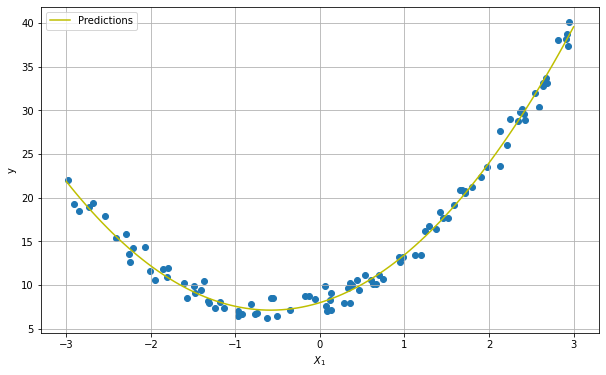

In [40]:
X_for_plot = np.linspace(-3,3,100).reshape(100,1)
X_poly_plot = poly_features.transform(X_for_plot)
y_for_plot = lin_reg_2.predict(X_poly_plot)

plt.figure(figsize = (10,6))
plt.scatter(X,y)
 
plt.plot(X_for_plot,y_for_plot,"y-",label = "Predictions")
plt.xlabel("$X_1$")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features $a^2$, $a^3$, $b^2$, and $b^3$, but also the combinations ab, $a^2b$, and $ab^2$.

## Learning Curves

These are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [42]:
def plot_learning_curve(model, X,y, ylim=(0,12)):
  X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)
  train_errors, val_errors = [], []
  for m in range(1, len(X_train)):
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
    val_errors.append(mean_squared_error(y_val,y_val_predict))
  plt.figure(figsize = (12,7))
  plt.plot(np.sqrt(train_errors),'r', label='train')
  plt.plot(np.sqrt(val_errors),'b', label='val')
  plt.grid(True)
  plt.ylim(ylim)
  plt.legend()
  plt.ylabel('RMSE')
  plt.xlabel('Training Set Size')
  plt.show()

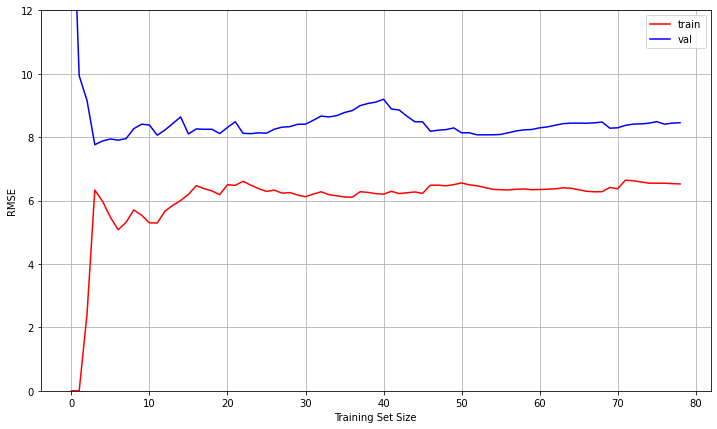

In [43]:
plot_learning_curve(lin_reg,X,y)

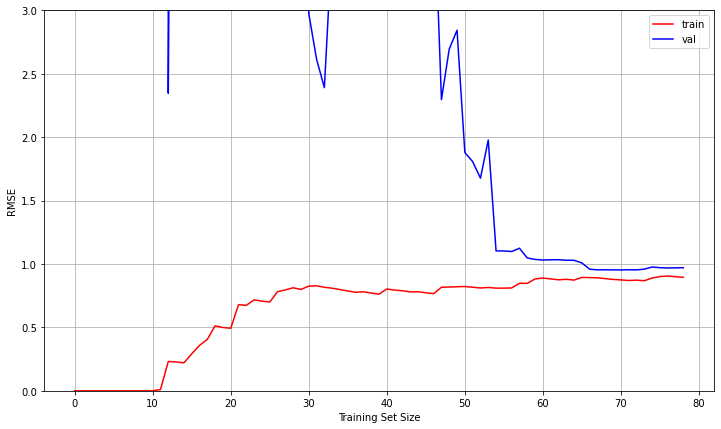

In [44]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curve(polynomial_regression, X, y,(0,3))

# Regularized Linear Models

# Ridge Regression
## also called Tikhonov regularization

In [45]:
np.random.seed(259)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

In [46]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha = 1, solver='cholesky', random_state=259)
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.56327932]])

In [47]:
sgd_reg = SGDRegressor(penalty='l2', random_state=259)
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


array([1.2151634])

'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

In [48]:
for solver in ('sag','saga'):
  ridge_reg = Ridge(alpha=1, solver=solver, random_state=259)
  ridge_reg.fit(X,y)
  print(ridge_reg.predict([[1.5]]))

[[1.56333487]]
[[1.56331844]]


# Lasso Regression

## Least Absolute Shrinkage and Selection Operator Regression

In [49]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.58573808])

# ElasticNet

In [50]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.5768546])

# Early Stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called early stopping. Figure shows a complex model (in this case, a high-degree Polynomial Regression model) being trained with Batch Gradient Descent. As the epochs go by the algorithm learns, and its prediction error (RMSE) on the training set goes down, along with its prediction error on the validation set. After a while though, the validation error stops decreasing and starts to go back up. This indicates that the model has started to overfit the training data. With early stopping you just stop training as soon as the validation error reaches the minimum. It is such a simple and efficient regularization technique that Geoffrey Hinton called it a “beautiful free lunch.”

In [51]:
from sklearn.preprocessing import StandardScaler

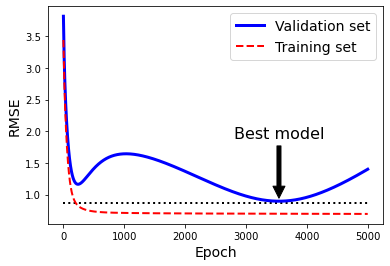

In [52]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 5000
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

In [53]:
from sklearn.base import clone

#prepare data

poly_scaler = Pipeline([
                        ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)),
                        ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, tol = np.infty, warm_start = True, penalty=None, learning_rate='constant', eta0=0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in range(1000):
  sgd_reg.fit(X_train_poly_scaled, y_train)
  y_val_predict = sgd_reg.predict(X_val_poly_scaled)
  val_error = mean_squared_error(y_val, y_val_predict)
  if val_error < minimum_val_error:
    minimum_val_error = val_error
    best_epoch = epoch
    best_model = clone(sgd_reg)

c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before converge

In [54]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.00972038]),
 array([ 1.04819093e+00,  1.18380600e+00,  2.72594161e-01,  5.79895453e-01,
         1.35562843e-01,  2.57394793e-01,  9.41896630e-02,  8.84097829e-02,
         5.83565291e-02, -1.43500968e-03,  2.27332260e-02, -5.13353112e-02,
        -8.06823678e-03, -8.01442145e-02, -3.17439998e-02, -9.67713075e-02,
        -4.82414667e-02, -1.05617774e-01, -5.85297923e-02, -1.09087753e-01,
        -6.38455223e-02, -1.08679441e-01, -6.53591693e-02, -1.05443557e-01,
        -6.40632677e-02, -1.00174648e-01, -6.07569064e-02, -9.34942835e-02,
        -5.60657130e-02, -8.58921552e-02, -5.04710087e-02, -7.77511527e-02,
        -4.43381018e-02, -6.93661085e-02, -3.79406066e-02, -6.09594866e-02,
        -3.14803592e-02, -5.26949794e-02, -2.51033941e-02, -4.46892517e-02,
        -1.89126455e-02, -3.70219211e-02, -1.29779964e-02, -2.97438774e-02,
        -7.34420208e-03, -2.28840956e-02, -2.03711306e-03, -1.64551239e-02,
         2.93146005e-03, -1.04574413e-02,  7.55996412e-03, -4.8828

In [55]:
best_model.__dict__

{'loss': 'squared_loss',
 'penalty': None,
 'learning_rate': 'constant',
 'epsilon': 0.1,
 'alpha': 0.0001,
 'C': 1.0,
 'l1_ratio': 0.15,
 'fit_intercept': True,
 'shuffle': True,
 'random_state': None,
 'verbose': 0,
 'eta0': 0.0005,
 'power_t': 0.25,
 'early_stopping': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': 5,
 'warm_start': True,
 'average': False,
 'n_iter': None,
 'max_iter': 1,
 'tol': inf}

In [56]:
best_epoch

226

# Logistic Regression

also called Logit Regression

In [57]:
from sklearn import datasets

In [58]:
iris = datasets.load_iris()
list(iris.keys())


['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [59]:
# petal_width
X = iris['data'][:,3:]

# 1 if Iris virginica, else 0
y = (iris['target'] == 2).astype(np.int)

In [60]:
from sklearn.linear_model import LogisticRegression

In [61]:
log_reg = LogisticRegression(n_jobs = -1)
log_reg.fit(X,y)

c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\shrey\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

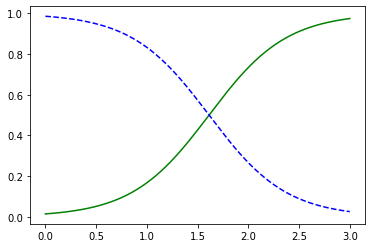

In [62]:
X_new = np.linspace(0,3,1000).reshape(-1,1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1],'g-', label = 'Iris Virginica')
plt.plot(X_new, y_proba[:,0],'b--', label = 'Not Iris Virginica')

In [63]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

[2.73609573 0.47781328]


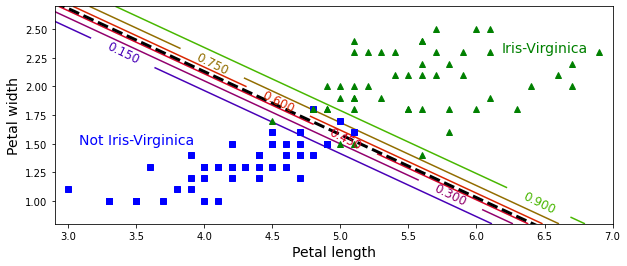

In [64]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="liblinear", C=10**10, random_state=42)
log_reg.fit(X, y)

x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

# print(y_proba)

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

print(boundary)

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris-Virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris-Virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
plt.show()

# Exercise
### Hands on Machine Learning Book

**Which Linear Regression training algorithm can you use if you have a training set with millions of features?**

If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.

**Suppose the features in your training set have very different scales. Which algorithms might suffer from this, and how? What can you do about it?**

If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.



**Can Gradient Descent get stuck in a local minimum when training a Logistic Regression model?**

Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex

**Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough?**

If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.

**Suppose you use Batch Gradient Descent and you plot the validation error at every epoch. If you notice that the validation error consistently goes up, what is likely going on? How can you fix this?**

If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.

**Is it a good idea to stop Mini-batch Gradient Descent immediately when the validation error goes up?**

Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.

**Which Gradient Descent algorithm (among those we discussed) will reach the vicinity of the optimal solution the fastest? Which will actually converge? How can you make the others converge as well?**

Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.

**Suppose you are using Polynomial Regression. You plot the learning curves and you notice that there is a large gap between the training error and the validation error. What is happening? What are three ways to solve this?**

If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ2 penalty (Ridge) or an ℓ1 penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.

**Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter α or reduce it?**

If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter α.

**Why would you want to use:**

**1. Ridge Regression instead of plain Linear Regression (i.e., without any regularization)?**

**2. Lasso instead of Ridge Regression?**

**3. Elastic Net instead of Lasso?**

- A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.

- Lasso Regression uses an ℓ1 penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.

- Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an l1_ratio close to 1.

**Suppose you want to classify pictures as outdoor/indoor and daytime/nighttime. Should you implement two Logistic Regression classifiers or one Softmax Regression classifier?**

If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.